# AIN212 Movie Review Classification Project

This project aims to classify movie reviews into positive or negative classes

### This project was made by:
### Adam Sattout - 2220765061
### Mukhamediyar Amanzhol - 2210765052

## Dataset:

We will use rotten tomatoes movie reviews dataset as given in the drive or in this link https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews

# 1. Data Preprocessing

## 1.1. Data Cleaning

We first load our data and see how it looks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Load the dataset

#This path hasn't been used since it didn't pass virus detection alert of Google drive
GoogleDrivePath = 'https://drive.google.com/uc?export=download&id=13Ry_jDFBHgyCQRxFPMExZYKAC-G-FlII'

path_to_dataset = 'rotten_tomatoes_movie_reviews.csv'
df = pd.read_csv(path_to_dataset)

df.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


We observed that in our dataset there exist features that cant really be used in our task since they dont provide necessary information (like reviewUrl and reviewId), and others that we tested and weren't able to find a correlation for them with our target feature (like isTopCritic, creationDate), so we remove those columns. We also encoded scoreSentiment to 0s and 1s to be easier to use. We also can see that originalScore isn't usable at the moment with different scales so we also need to deal with this

In [2]:
df.drop(columns = ['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic', 'reviewState', 'publicatioName', 'reviewUrl'], inplace = True)
df['scoreSentiment'] = df['scoreSentiment'].replace({'NEGATIVE': 0, 'POSITIVE': 1})

In [3]:
#Check for null values
print(df.isnull().sum())

originalScore     435218
reviewText         69225
scoreSentiment         0
dtype: int64


We see that there are some null values so we need to deal with them, first we remove reviewText nulls since they can't really imputed naturally, then we make originalScore accessable.

In [4]:
df = df.dropna(subset=['reviewText'])

In [5]:
# We apply this function that if string of originalScore is a fraction, returns a percentage. If not, returns null
def convert_fraction_to_float(data):
    if pd.isna(data):
        return
    match = re.search(r'[0-9]+(\.[0-9]+)?\/[0-9]+(\.[0-9]+)?', data)
    if match:
        numerator, denominator = map(float, match.group().split('/'))
        if denominator != 0:
            return  numerator / denominator
        else: 
            return 0
    else:
        return None
    
df['originalScore'] = df['originalScore'].apply(convert_fraction_to_float)

# Checks if a score is higher than 100% or lower than 0%, meaning that it is a faulty submission and turns it into 
# 100%/0% respectively
df['originalScore'] = df['originalScore'].apply(lambda x: 1 if x > 1 else x)
df['originalScore'] = df['originalScore'].apply(lambda x: 0 if x < 0 else x)

# Removes rows that have score as null
df = df.dropna(subset=['originalScore'])

We tried imputing null values. However, it turned out to have a negative impact on our results, it could be since there are lots of null values. We didnt find a way to impute it since modeling needs more features and median has the same issue so we removed them

In [6]:
count_0 = df['scoreSentiment'].value_counts().get(0, 0)
count_1 = df['scoreSentiment'].value_counts().get(1, 0)

# Display the counts
print("Count of 0s:", count_0)
print("Count of 1s:", count_1)

Count of 0s: 262569
Count of 1s: 518272


We can see that our dataset is imbalanced towards positive reviews, so to get unbiased results in our future model we need to make it balanced. If we remove half of the positive rows randomly, we would get a balanced dataset

In [7]:
true_rows = df[df['scoreSentiment'] == 1]

rows_to_remove = true_rows.sample(frac=0.5, random_state = 40)

df_balanced = df.drop(rows_to_remove.index)

In [8]:
# We take a sample from the balanced dataset
# This version was run with a sample of 100k elements which took 50 minutes to run, change n if a faster computation
# is needed
df_sample = df_balanced.sample(n=100000, random_state = 40)

## 1.2. Feature Adding

In this part we are going to add multiple features deduced from the textReview part using multiple datasets as a refrence for positive/negative words, and sentiment lexicon scores indicating how positive/negative they are

Sentiment Lexicon Scores Dataset: https://www.kaggle.com/datasets/andradaolteanu/bing-nrc-afinn-lexicons

Positive/Negative Words Dataset: https://www.kaggle.com/datasets/mukulkirti/positive-and-negative-word-listrar

## 1.2.1. Calculating new features

In [9]:
#Import necessary libraries
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [10]:
#retreive word lists

WordListDrivePath = 'https://drive.google.com/uc?export=download&id=116rKDYi5oKvWrnF9LnIy1Odw7Nn4q5mE'
goodBadDf = pd.read_excel("goodBadDf.xlsx")
positiveWordList = goodBadDf['Positive Sense Word List'].dropna().tolist()
negativeWordList = goodBadDf['Negative Sense Word List'].dropna().tolist()

LexiconsDrivePath = 'https://drive.google.com/uc?export=download&id=1SvgUpGDDgZxmqFLTXZ9MEiTzJ-5Twtn3'
dfLexicon = pd.read_csv("Afinn.csv",  encoding='ISO-8859-1')

In [11]:
#Calculates subjectivity
def calculate_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity


df_sample['subjectivity'] = df_sample['reviewText'].apply(calculate_subjectivity)

In [12]:
#Calculates polarity
def calculate_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


df_sample['polarity'] = df_sample['reviewText'].apply(calculate_polarity)

In [13]:
#prepare a function that turns reviewText column into a list of lemmatized processed words and apply it
lemma = WordNetLemmatizer()
stop_words = stopwords.words('english')

def text_prep(x):
     corp = str(x).lower() 
     corp = re.sub('[^a-zA-Z]+',' ', corp).strip() 
     tokens = word_tokenize(corp)
     words = [t for t in tokens if t not in stop_words]
     lemmatize = [lemma.lemmatize(w) for w in words]
    
     return lemmatize
    
df_sample['processedText'] = df_sample['reviewText'].apply(text_prep)

In [14]:
#Calculate total length of the review after being processed
df_sample['total_len'] = df_sample['processedText'].map(lambda x: len(x))

In [15]:
#Get the cound of positive/negative words in processed text
df_sample['posCount'] = df_sample['processedText'].map(lambda x: len([i for i in x if i in positiveWordList]))
df_sample['negCount'] = df_sample['processedText'].map(lambda x: len([i for i in x if i in negativeWordList]))

#Calculate the ratio of positive/negative words in the processed text
df_sample['posRatio'] = round(df_sample['posCount'] / df_sample['total_len'], 2)
df_sample['negRatio'] = round(df_sample['negCount'] / df_sample['total_len'], 2)

#Calculate a new feature called 'sentiment' that is the difference of counts over the length of the processed review
df_sample['sentiment'] = round((df_sample['posCount'] - df_sample['negCount']) / df_sample['total_len'], 2)

In [16]:
#Calculate sentiment lexicon based on the mean of values of each word in the processed text 
def calculate_average_score(words_list):
    word_scores = dfLexicon[dfLexicon['word'].isin(words_list)]['value']
    return word_scores.mean() if not word_scores.empty else 0

# Apply the function to the 'words_list' column in df_main
df_sample['average_lexicon_score'] = df_sample['processedText'].apply(calculate_average_score)

In [17]:
#Determines whether the review has negation in it, this is to consider phrases like 'not good'
negation_words = ['not', 'never', 'no', 'none', 'nobody', 'nowhere', 'nothing', 'neither', 'nor']

def has_negation(text):
    return any(word in text for word in negation_words)

# Apply the function to create a new 'negation' column in the DataFrame
df_sample['negation'] = df_sample['reviewText'].apply(has_negation)
df_sample['negation'] = df_sample['negation'].astype(int)

In [18]:
# Drop null values in case a wrong calculation happens (sometimes it results in 1 null value for the whole sample this is to 
# fix that)
df_sample = df_sample.dropna()

## 1.2.2. Handling outliers

After all the new features are added, we can handle the outliers. We used IQR to determine our outliers and imputed them using the mean of each feature

In [19]:
for feature in df_sample.columns:
    if feature != 'sentimentScore' and df_sample[feature].dtype != 'object':
        mean_value = df_sample[feature].mean()
        Q1 = df_sample[feature].quantile(0.25)
        Q3 = df_sample[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_sample[feature] < (Q1 - 1.5 * IQR)) | (df_sample[feature] > (Q3 + 1.5 * IQR))
        df_sample.loc[outlier_mask, feature] = mean_value

We tried applying scaling to our data. However, it had bad results in our modeling so we found out that its is best to leave it as it is. It is probably due to most of our features already falling in range [0,1] so they dont need scaling.

# 2. Data Exploration and Analysis

## 2.1. Exploring our data

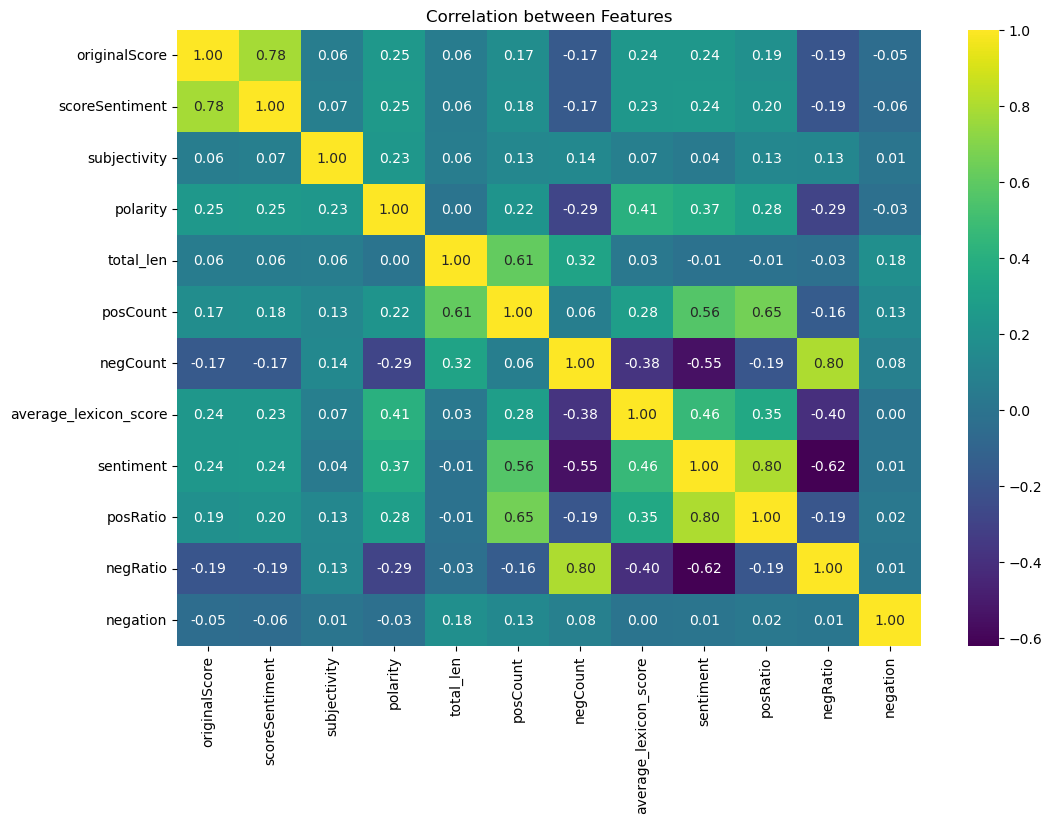

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_sample[['originalScore', 'scoreSentiment', 'subjectivity','polarity', 'total_len', 'posCount', 'negCount',
                       'average_lexicon_score', 'sentiment', 'posRatio','negRatio', 'negation']].corr(), annot=True,
                        cmap='viridis', fmt=".2f")
plt.title('Correlation between Features')
plt.show()

We can see that originalScore has the biggest correlation with our target feature scoreSentiment, while others fall quite short. We can also see that some features are strongly correlated with eachother like counts, ratios and sentiment which is expected since they are derived from eachother

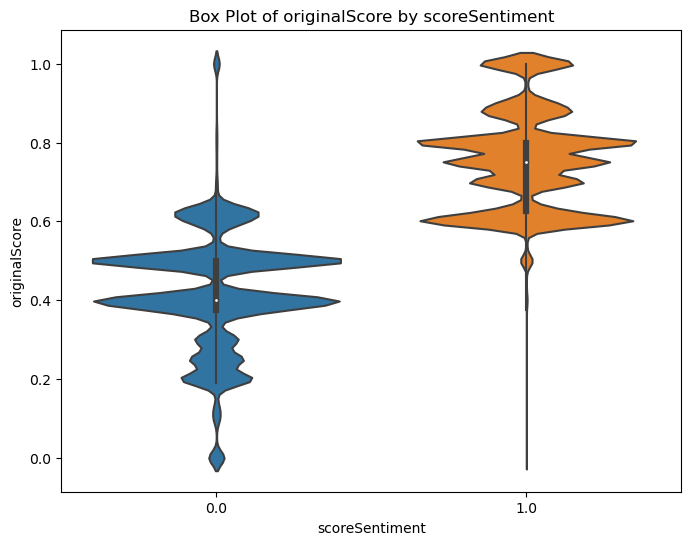

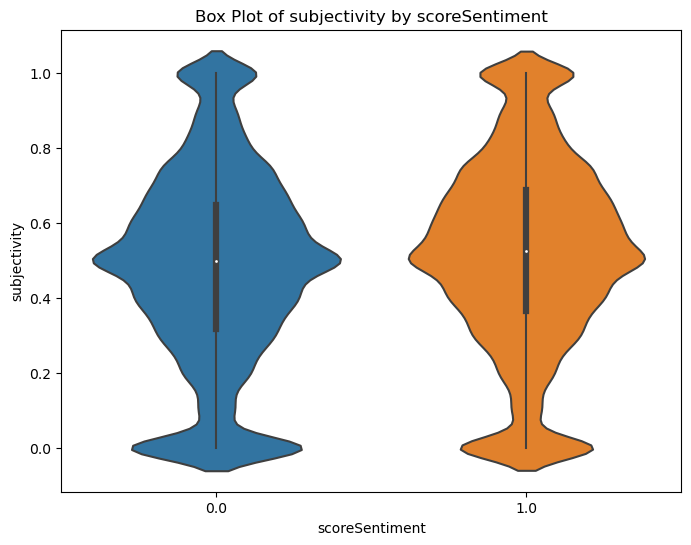

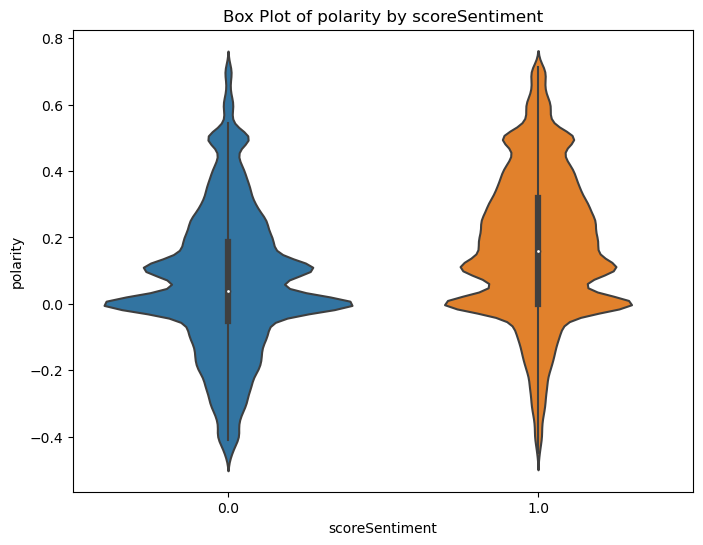

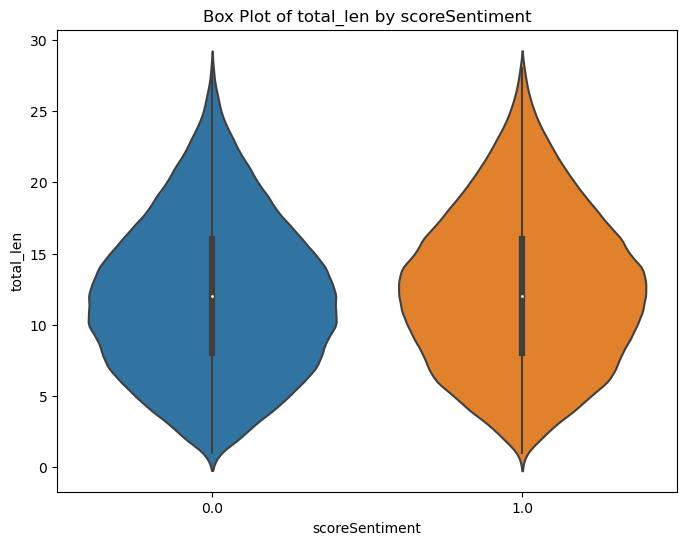

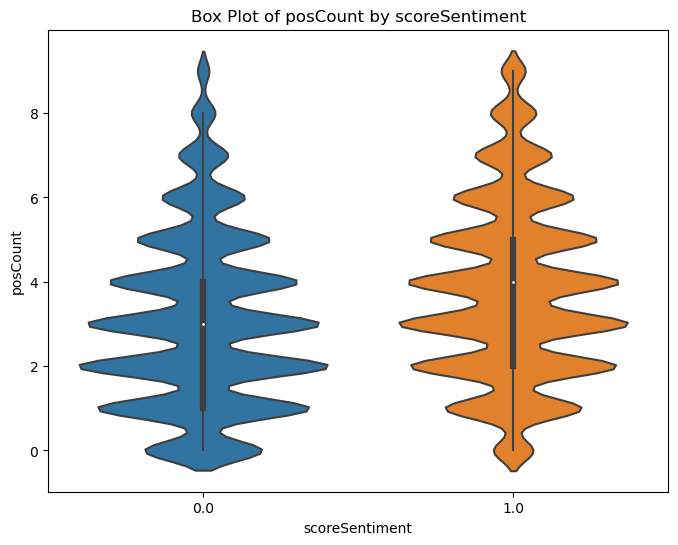

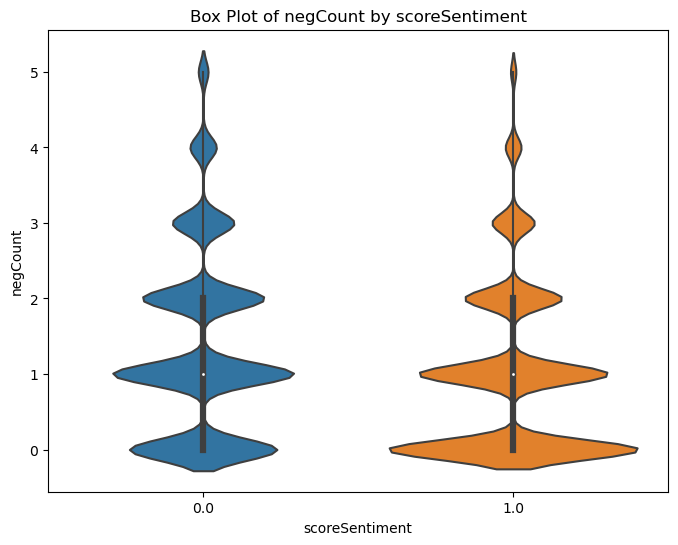

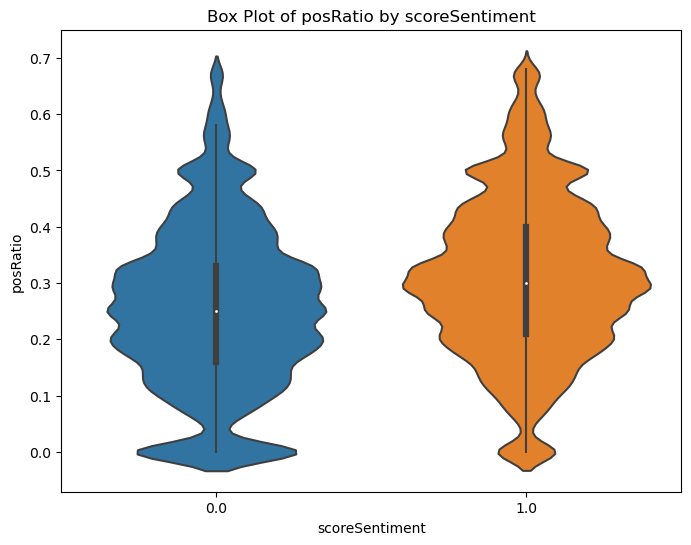

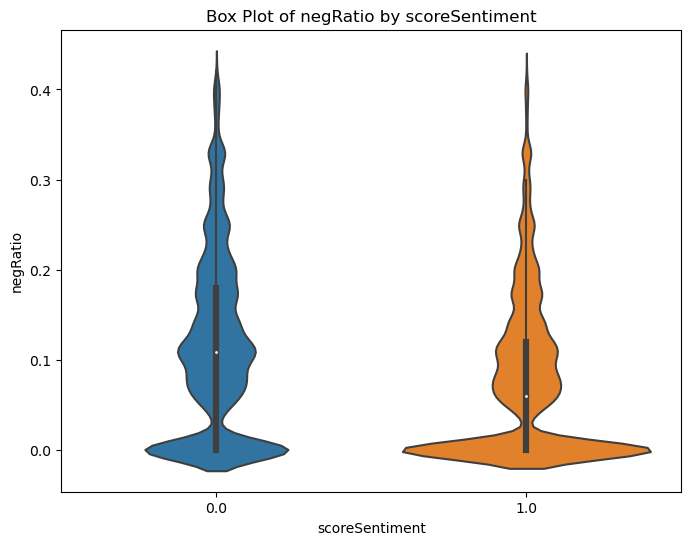

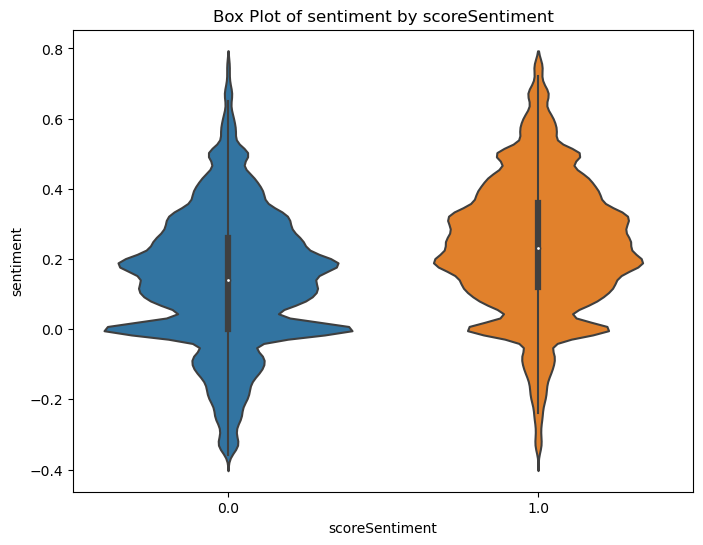

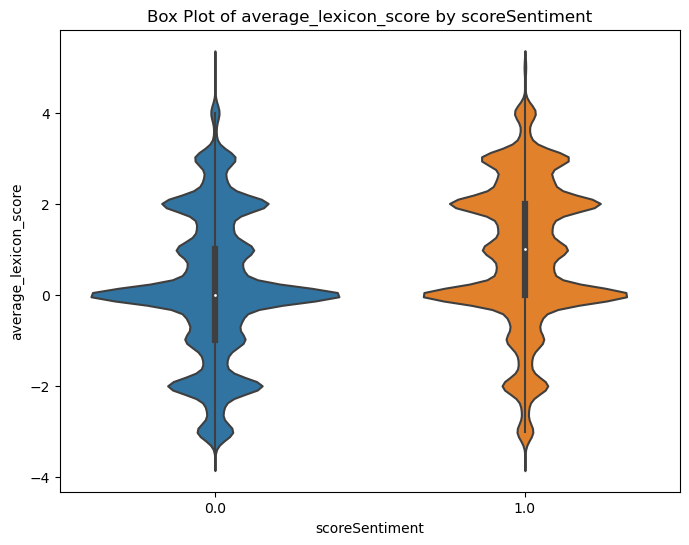

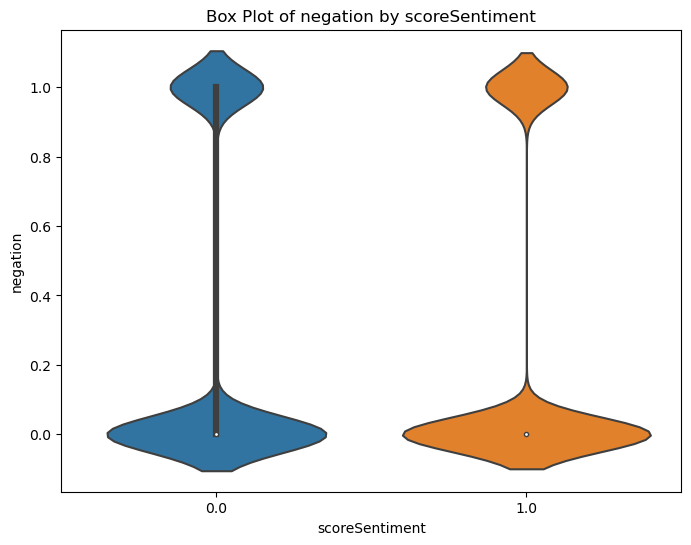

In [21]:
for feature in df_sample.columns:
    if feature != 'scoreSentiment' and df_sample[feature].dtype != 'object':
        plt.figure(figsize=(8, 6))
        sns.violinplot(x=df_sample['scoreSentiment'], y=df_sample[feature], data=df_sample)
        plt.title(f'Box Plot of {feature} by scoreSentiment')
        plt.show()

As expected from our heatmap, our violin plots dont show a direct correlation between our feature target and other features for the most part. Some features show slight correlation. However, we can see a fairly strong correlation when we look at the violin plot representing originalScore and scoreSentiment.

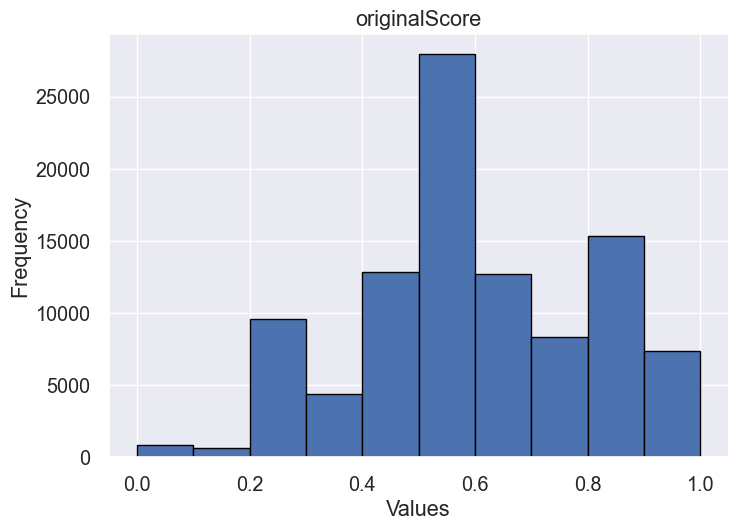

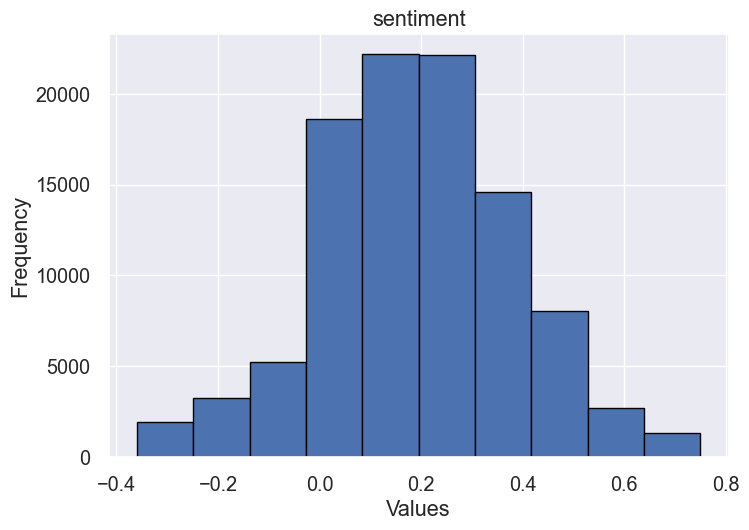

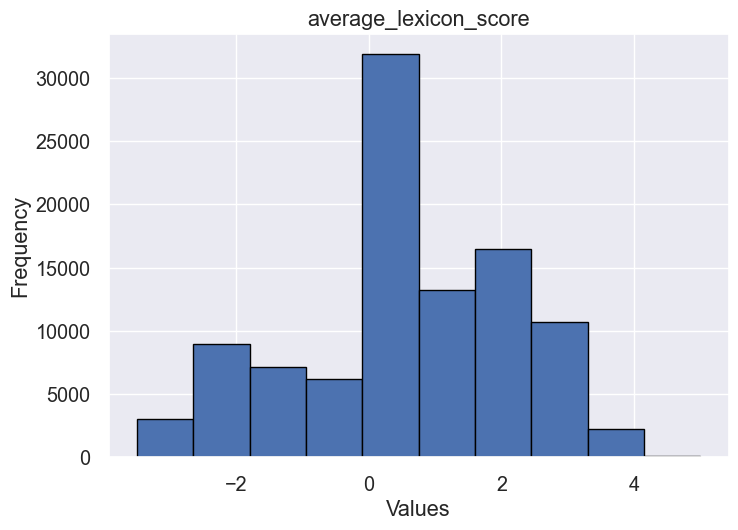

In [150]:
features = ['originalScore', 'sentiment', 'average_lexicon_score']


for feature in features:
    plt.hist(df_sample[feature], bins=10, edgecolor='black')  # Adjust the number of bins as needed
    plt.title(feature)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()

If we plot the distribution of 3 of the most correlated features to our target feature, we can see that even if most of the data lies on neutral for these features, it seems like the features lean to being positive (especially for sentiment), even though our sample is fairly balanced as we see in the next graph. This might be the reason they have a low correlation score with the target feature

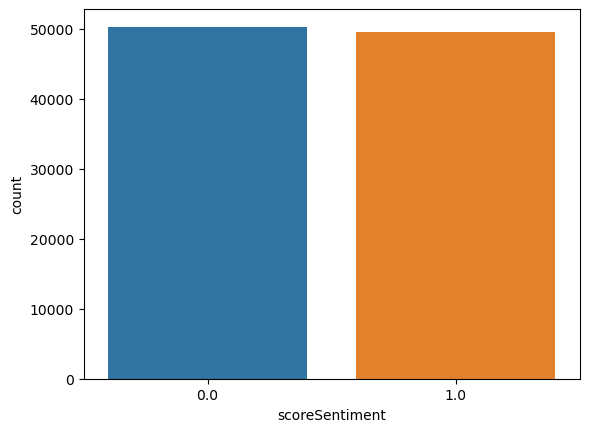

In [23]:
sns.countplot(x='scoreSentiment', data=df_sample)
plt.show()

In [24]:
df_sample.describe()

,originalScore,scoreSentiment,subjectivity,polarity,total_len,posCount,negCount,posRatio,negRatio,sentiment,average_lexicon_score,negation
count,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000,99989.000000
mean,0.587199,0.496555,0.497559,0.117997,12.197813,3.415772,1.200143,0.283080,0.097937,0.188467,0.523016,0.272500
std,0.214762,0.499991,0.260860,0.221428,5.347322,2.092426,1.185729,0.146287,0.096341,0.194006,1.608170,0.445248
min,0.000000,0.000000,0.000000,-0.453571,1.000000,0.000000,0.000000,0.000000,0.000000,-0.360000,-3.500000,0.000000
25%,0.400000,0.000000,0.343056,0.000000,8.000000,2.000000,0.000000,0.180000,0.000000,0.060000,-0.250000,0.000000
50%,0.600000,0.000000,0.500000,0.108370,12.000000,3.000000,1.000000,0.290000,0.080000,0.182409,0.142857,0.000000
75%,0.750000,1.000000,0.666667,0.254167,16.000000,5.000000,2.000000,0.380000,0.150000,0.320000,2.000000,1.000000
max,1.000000,1.000000,1.000000,0.712500,28.000000,9.000000,5.000000,0.680000,0.420000,0.750000,5.000000,1.000000


## 2.2. Clustering

As a result of our data having high dimensions, we need to apply PCA before clustering with kMeans

In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

In [26]:
# Remove textual data for PCA
df_for_pca = df_sample.drop('reviewText', axis=1)
df_for_pca = df_for_pca.drop('processedText', axis=1)

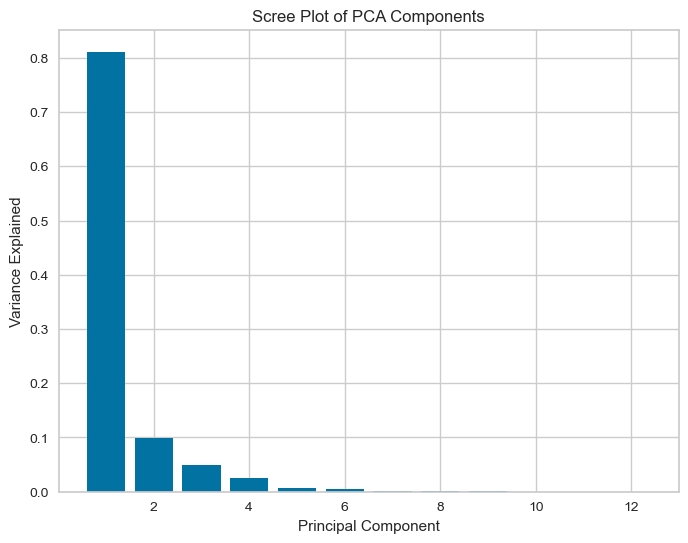

In [27]:
from sklearn.decomposition import PCA
df_for_pca = df_for_pca - df_for_pca.mean()

pca = PCA()
df_pca = pca.fit_transform(df_for_pca)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot of PCA Components')
plt.show()

In this scree plot, it is shown that more than 90% of the variance is covered by the first 2 PCs, so using 2 will be enough

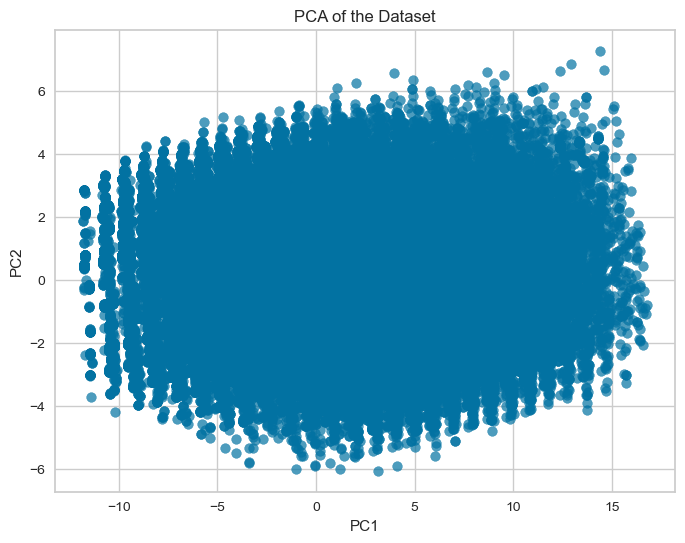

In [28]:
#Showing first 2 PC scatter plot

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of the Dataset')
plt.grid(True)
plt.show()

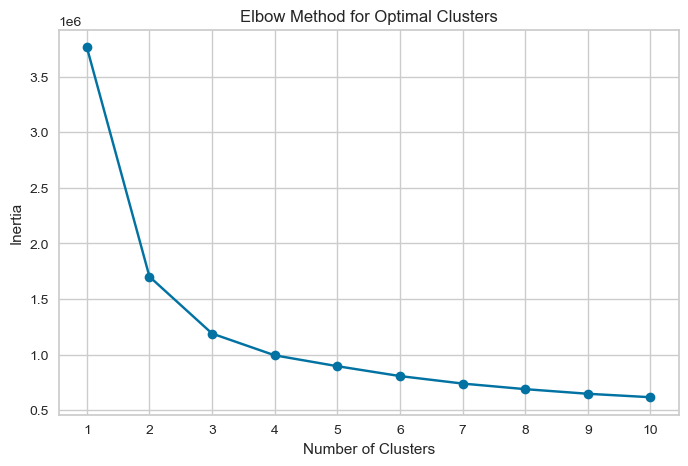

In [29]:
inertia = []
for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters=i, random_state=0)
    kmeans_pca.fit(df_pca)
    inertia.append(kmeans_pca.inertia_)

# Plotting the Elbow Method Graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


Although we have 2 classes, it is shown that data is best split into 3 clusters with k = 3, so both will be done

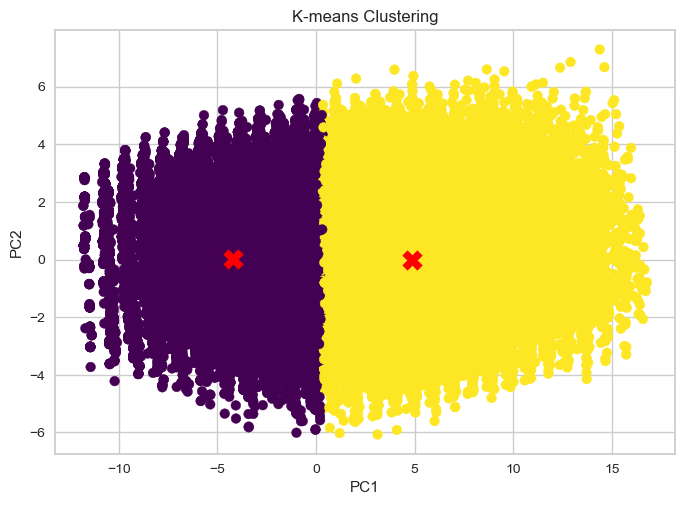

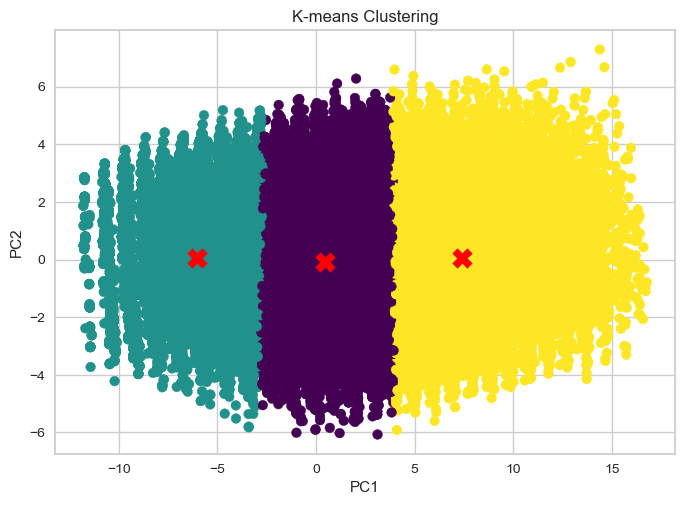

In [30]:
for i in range(2,4):
    kmeans_pca = KMeans(n_clusters=i, random_state=0)
    clusters_pca = kmeans_pca.fit_predict(df_pca)

    plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_pca, cmap='viridis')
    plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('K-means Clustering')
    plt.show()

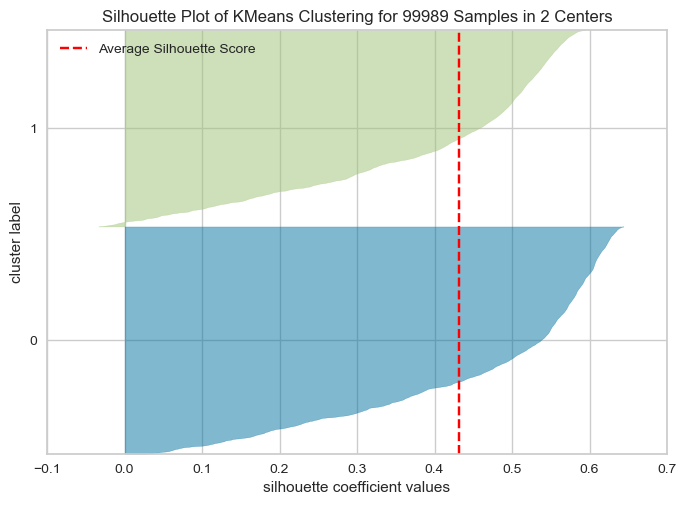

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 99989 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
kmeans_pca = KMeans(n_clusters=2, random_state=0)

visualizer = SilhouetteVisualizer(kmeans_pca, colors='yellowbrick')
visualizer.fit(df_pca)
visualizer.show()

As we can see we weren't able to have meaningful clusters from our PCA, the clusters shown in the graph weren't really significent and if we look at the silhouette coefficient values they aren't good either having a slightly more than 0.4 as the average

# 3. Modeling

For creating our models we wanted to see how much of an impact adding the review score 'originalScore' would make, so we opted for using logistic regression, KNN classification and Forest Dense Classification with and without the review score. Since we saw a low linear correlation between all features except the review score and scoreSentiment then we expect that adding original score to logistic regression and KNN would make a big difference. We will also try using Word Embedding

## 3.1. Modeling without using originalScore

In [32]:
X = df_sample[[ 'subjectivity','polarity', 'total_len', 'posCount', 'negCount', 'average_lexicon_score', 'sentiment',
               'posRatio','negRatio','negation']]

Y = df_sample['scoreSentiment']

### 3.1.1 Logistic Regrission

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from warnings import simplefilter

In [34]:
# We will keep results of each model in a list to evaluate at the end
model_results = []

In [35]:
model = LogisticRegression(max_iter=2000)

#Using KFold Cross Validation
kf = KFold(n_splits= 10, shuffle=True, random_state=42)

log_ypred = cross_val_predict(model, X, Y, cv=kf)
conf_mat = confusion_matrix(Y, log_ypred)

In [36]:
fpr, tpr, thresholds_roc = roc_curve(Y, log_ypred)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(Y, log_ypred)
pr_auc = average_precision_score(Y, log_ypred)

model_results.append({'Model': 'Logistic Regression',
                      'Accuracy': accuracy_score(Y, log_ypred),
                      'Precision': precision_score(Y, log_ypred),
                      'Recall': recall_score(Y, log_ypred),
                      'F1 Score': f1_score(Y, log_ypred),
                      'Confusion' : conf_mat,
                      'ROC Curve': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'thresholds': thresholds_roc.tolist(), 'auc': roc_auc},
                      'PR Curve': {'precision': precision.tolist(), 'recall': recall.tolist(), 'thresholds': thresholds_pr.tolist(), 'auc': pr_auc}})


### 3.1.2. KNN-Classification

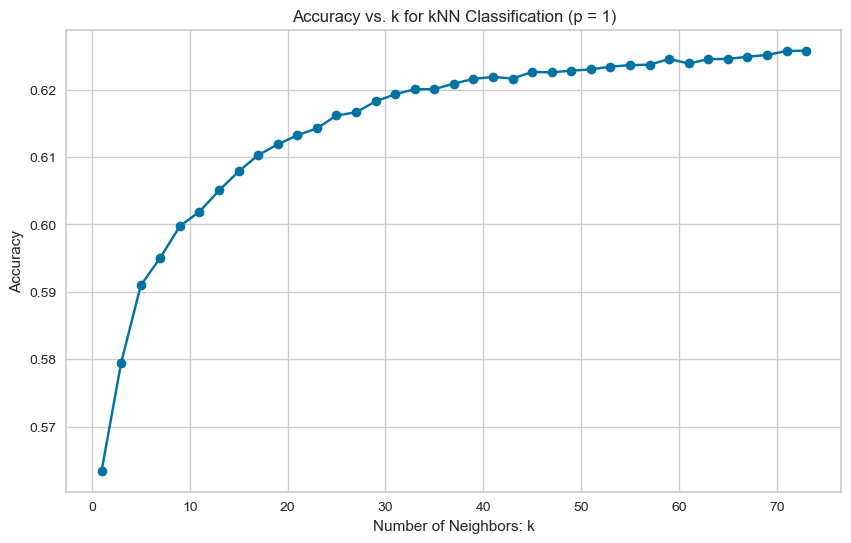

In [37]:
simplefilter(action='ignore', category=FutureWarning)

accuracyValues = []
kValues = range(1, 75, 2)

for k in kValues:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)

    kf = KFold(n_splits= 10, shuffle=True, random_state=42)
    knn_ypred = cross_val_predict(knn, X, Y, cv=kf)

    accuracy = accuracy_score(Y, knn_ypred)
    accuracyValues.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(kValues, accuracyValues, marker='o')
plt.title('Accuracy vs. k for kNN Classification (p = 1)')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuracy')
plt.show()

In [38]:
#Obtain optimal k value, make a model with it and get its predictions and accuracy
optimal_k = kValues[accuracyValues.index(max(accuracyValues))]
knnOptimal = KNeighborsClassifier(n_neighbors=optimal_k, metric='minkowski', p=1)

kf = KFold(n_splits= 10, shuffle=True, random_state=42)

knn_ypred = cross_val_predict(knnOptimal, X, Y, cv=kf)
conf_mat = confusion_matrix(Y, knn_ypred)

In [39]:
fpr, tpr, thresholds_roc = roc_curve(Y, knn_ypred)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(Y, knn_ypred)
pr_auc = average_precision_score(Y, knn_ypred)

model_results.append({'Model': 'KNN',
                      'Accuracy': accuracy_score(Y, knn_ypred),
                      'Precision': precision_score(Y, knn_ypred),
                      'Recall': recall_score(Y, knn_ypred),
                      'F1 Score': f1_score(Y, knn_ypred),
                      'Confusion' : conf_mat,
                      'ROC Curve': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'thresholds': thresholds_roc.tolist(), 'auc': roc_auc},
                      'PR Curve': {'precision': precision.tolist(), 'recall': recall.tolist(), 'thresholds': thresholds_pr.tolist(), 'auc': pr_auc}})


### 3.1.3 Random Forest Classification

Random Forest Classification is an algorithm that creates multiple decision trees by taking random features and random samples into account when creating each decision tree. Then when a new query arrives it counts the votes of what each decision tree classifies the query and gets the heighest. Both using a vectorizer for features in random forest classification and using features we calculated before were tried, and we found out that vectorizing yielded better results 

In [40]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

df_words = df_sample.copy()
df_words['preprocessed_text'] = df_words['reviewText'].apply(preprocess_text)

In [41]:
X = df_words['preprocessed_text']
Y = df_words['scoreSentiment']

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [42]:
kf = KFold(n_splits= 10, shuffle=True, random_state=42)

forest_ypred = cross_val_predict(rf_classifier, X_tfidf, Y, cv=kf)
conf_mat = confusion_matrix(Y, forest_ypred)


In [43]:
fpr, tpr, thresholds_roc = roc_curve(Y, forest_ypred)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(Y, forest_ypred)
pr_auc = average_precision_score(Y, forest_ypred)

model_results.append({'Model': 'Random Forest',
                      'Accuracy': accuracy_score(Y, forest_ypred),
                      'Precision': precision_score(Y, forest_ypred),
                      'Recall': recall_score(Y, forest_ypred),
                      'F1 Score': f1_score(Y, forest_ypred),
                      'Confusion' : conf_mat,
                      'ROC Curve': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'thresholds': thresholds_roc.tolist(), 'auc': roc_auc},
                      'PR Curve': {'precision': precision.tolist(), 'recall': recall.tolist(), 'thresholds': thresholds_pr.tolist(), 'auc': pr_auc}})


## 3.2. Modeling using originalScore

In [44]:
X = df_sample[['originalScore','subjectivity','polarity', 'total_len', 'posCount', 'negCount',
                'average_lexicon_score', 'sentiment', 'posRatio', 'negRatio', 'negation']]

Y = df_sample['scoreSentiment']

### 3.2.1 Logistic Regrission

In [45]:
model = LogisticRegression(max_iter=1000)

kf = KFold(n_splits= 10, shuffle=True, random_state=42)

log_ypred = cross_val_predict(model,X, Y, cv=kf)
conf_mat = confusion_matrix(Y, log_ypred)

In [46]:
fpr, tpr, thresholds_roc = roc_curve(Y, log_ypred)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(Y, log_ypred)
pr_auc = average_precision_score(Y, log_ypred)

model_results.append({'Model': 'Logistic Regression',
                      'Accuracy': accuracy_score(Y, log_ypred),
                      'Precision': precision_score(Y, log_ypred),
                      'Recall': recall_score(Y, log_ypred),
                      'F1 Score': f1_score(Y, log_ypred),
                      'Confusion' : conf_mat,
                      'ROC Curve': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'thresholds': thresholds_roc.tolist(), 'auc': roc_auc},
                      'PR Curve': {'precision': precision.tolist(), 'recall': recall.tolist(), 'thresholds': thresholds_pr.tolist(), 'auc': pr_auc}})


### 3.2.2 KNN Classification

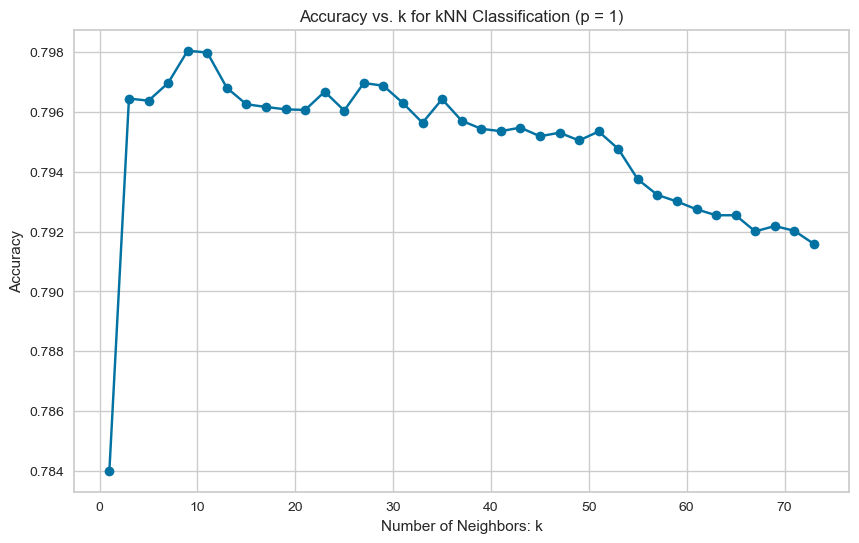

In [47]:
simplefilter(action='ignore', category=FutureWarning)

accuracyValues = []
kValues = range(1, 75, 2)

for k in kValues:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)

    kf = KFold(n_splits= 10, shuffle=True, random_state=42)
    knn_ypred = cross_val_predict(knn, X, Y, cv=kf)

    accuracy = accuracy_score(Y, knn_ypred)
    accuracyValues.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(kValues, accuracyValues, marker='o')
plt.title('Accuracy vs. k for kNN Classification (p = 1)')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuracy')
plt.show()

In [48]:
#Obtain optimal k value, make a model with it and get its predictions and accuracy
optimal_k = kValues[accuracyValues.index(max(accuracyValues))]
knnOptimal = KNeighborsClassifier(n_neighbors=optimal_k, metric='minkowski', p=1)

kf = KFold(n_splits= 10, shuffle=True, random_state=42)

knn_ypred = cross_val_predict(knnOptimal, X, Y, cv=kf)
conf_mat = confusion_matrix(Y, knn_ypred)

In [49]:
fpr, tpr, thresholds_roc = roc_curve(Y, knn_ypred)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(Y, knn_ypred)
pr_auc = average_precision_score(Y, knn_ypred)

model_results.append({'Model': 'KNN',
                      'Accuracy': accuracy_score(Y, knn_ypred),
                      'Precision': precision_score(Y, knn_ypred),
                      'Recall': recall_score(Y, knn_ypred),
                      'F1 Score': f1_score(Y, knn_ypred),
                      'Confusion' : conf_mat,
                      'ROC Curve': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'thresholds': thresholds_roc.tolist(), 'auc': roc_auc},
                      'PR Curve': {'precision': precision.tolist(), 'recall': recall.tolist(), 'thresholds': thresholds_pr.tolist(), 'auc': pr_auc}})


### 3.2.3 Random Forest Classification

This time we are using features in our sample dataframe

In [50]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

kf = KFold(n_splits= 10, shuffle=True, random_state=42)

forest_ypred = cross_val_predict(rf_classifier, X, Y, cv=kf)
conf_mat = confusion_matrix(Y, forest_ypred)

In [51]:
fpr, tpr, thresholds_roc = roc_curve(Y, forest_ypred)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(Y, forest_ypred)
pr_auc = average_precision_score(Y, forest_ypred)

model_results.append({'Model': 'Random Forest',
                      'Accuracy': accuracy_score(Y, forest_ypred),
                      'Precision': precision_score(Y, forest_ypred),
                      'Recall': recall_score(Y, forest_ypred),
                      'F1 Score': f1_score(Y, forest_ypred),
                      'Confusion' : conf_mat,
                      'ROC Curve': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'thresholds': thresholds_roc.tolist(), 'auc': roc_auc},
                      'PR Curve': {'precision': precision.tolist(), 'recall': recall.tolist(), 'thresholds': thresholds_pr.tolist(), 'auc': pr_auc}})


## 3.3 Modeling Using Word Embedding

Words Embedding is a way to explain words in vectors such that words closer in meanings are close to each other in the vector space, so for this part. We first get each word's vector based on the pretrained model that we have, being trained on Google news, and get the average of each dimension for all the words in the sentence. so our dataset will have 300 dimensions each of them being the average of the value of a word in that dimension

Word Embedding Based on Google News Pre-trained Model: https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300/discussion/467404

In [52]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [53]:
# Downloading model and assigning its path into word2vec_model_path might be needed, wasn't able to test it due to not being
# able to download it from the link in the notebook since it is large (1.5GB)
word2vec_model_googledrive_path = 'https://drive.google.com/uc?export=download&id=1p_gRNtaY6McwapjRhxfKtpFJOs2FLmY9'

word2vec_model_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [54]:
def get_average_word_embedding(text, word_embedding_model):
    words = text.split()
    embeddings = [word_embedding_model[word] for word in words if word in word_embedding_model]
    
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word_embedding_model.vector_size)

df_words['word_embeddings'] = df_words['preprocessed_text'].apply(lambda x: get_average_word_embedding(x, word2vec_model))

In [55]:
embedding_sample = df_words['word_embeddings'].iloc[0]
embedding_dim = len(embedding_sample)
df_word_embeddings = pd.DataFrame(df_words['word_embeddings'].tolist(), columns=[f'embedding_{i}' for i in range(embedding_dim)])

In [56]:
X = df_word_embeddings
Y = df_sample['scoreSentiment']

### 3.3.1 Logistic Regression

In [57]:
model = LogisticRegression(max_iter=2000)

#Using KFold Cross Validation
kf = KFold(n_splits= 10, shuffle=True, random_state=42)

log_ypred = cross_val_predict(model, X, Y, cv=kf)
conf_mat = confusion_matrix(Y, log_ypred)

In [58]:
fpr, tpr, thresholds_roc = roc_curve(Y, log_ypred)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, thresholds_pr = precision_recall_curve(Y, log_ypred)
pr_auc = average_precision_score(Y, log_ypred)

model_results.append({'Model': 'Logistic Regression ',
                      'Accuracy': accuracy_score(Y, log_ypred),
                      'Precision': precision_score(Y, log_ypred),
                      'Recall': recall_score(Y, log_ypred),
                      'F1 Score': f1_score(Y, log_ypred),
                      'Confusion' : conf_mat,
                      'ROC Curve': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'thresholds': thresholds_roc.tolist(), 'auc': roc_auc},
                      'PR Curve': {'precision': precision.tolist(), 'recall': recall.tolist(), 'thresholds': thresholds_pr.tolist(), 'auc': pr_auc}})

df_word_embeddings.shape

(99989, 300)

Doing KNN Classification and Random Forest Classification on this kind of data that has that has this huge number of features needs large computational power and takes alot of time so to test word embeddings we opted to only use logistic regression

# 4. Model Evaluation and Visualizations


## 4.1 Models without originalScore


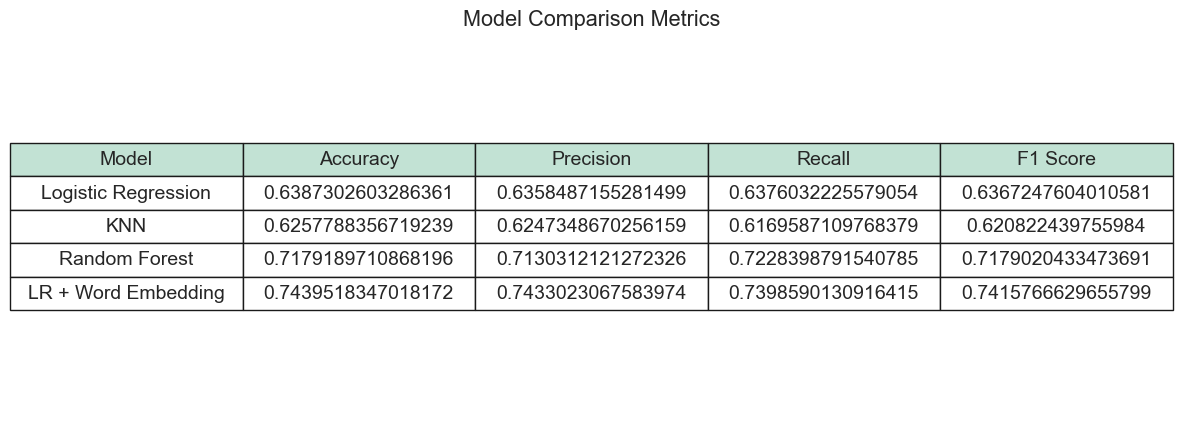

In [155]:
df_results = pd.DataFrame(model_results[i] for i in [0, 1, 2, 6])

fig, ax = plt.subplots(figsize=(15, 5))

ax.axis('off')

table = ax.table(cellText=df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].values,
                 colLabels=df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].columns,
                 loc='center', cellLoc='center', colColours=['#c2e2d4']*df_results.shape[1])

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

plt.title('Model Comparison Metrics')
plt.show()

We can see in the table above the 4 metrics of all models done without the review score, and as we can see, logistic regression with word embedding did the best across all metrics with values close to 74%, coming after it the Random Forest Classification with 71%. At the end we can see logistic regression doing slightly better than KNN accross all metrics with both falling below 64%

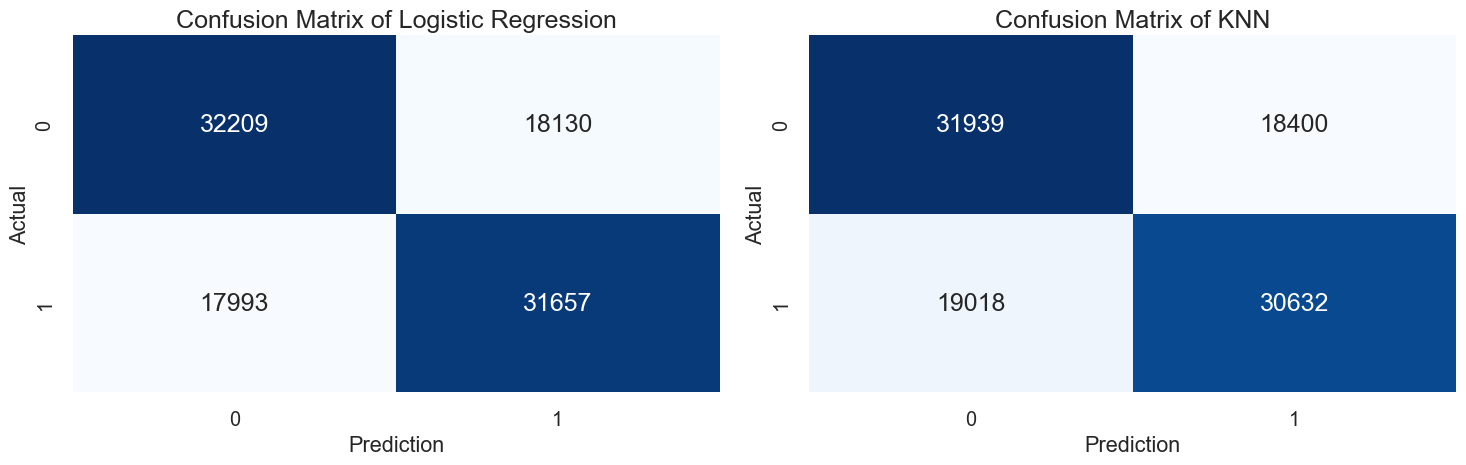

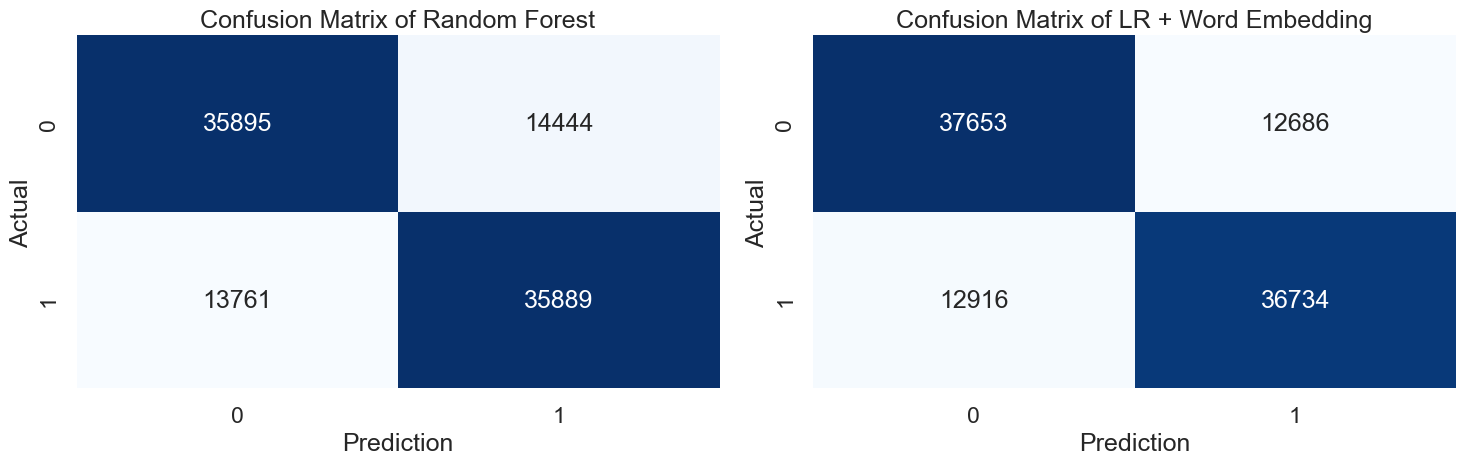

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 

sns.set(font_scale=1.5)

sns.heatmap(model_results[0]['Confusion'], annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'], ax=axs[0])

axs[0].set_xlabel('Prediction')
axs[0].set_ylabel('Actual')
axs[0].set_title(f'Confusion Matrix of ' + model_results[0]['Model'])

sns.heatmap(model_results[1]['Confusion'], annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'], ax=axs[1])

axs[1].set_xlabel('Prediction')
axs[1].set_ylabel('Actual')
axs[1].set_title(f'Confusion Matrix of ' + model_results[1]['Model'])

plt.tight_layout()

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 

sns.heatmap(model_results[2]['Confusion'], annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'], ax=axs[0])

axs[0].set_xlabel('Prediction')
axs[0].set_ylabel('Actual')
axs[0].set_title(f'Confusion Matrix of ' + model_results[2]['Model'])


sns.heatmap(model_results[6]['Confusion'], annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'], ax=axs[1])

axs[1].set_xlabel('Prediction')
axs[1].set_ylabel('Actual')
axs[1].set_title(f'Confusion Matrix of ' + model_results[6]['Model'])

plt.tight_layout()

In [157]:
models = []
matrices = []
roc_curves = []
pr_curves = []
precisions = []
recalls = []

for i in [0, 1, 2, 6]:
    models.append(model_results[i]['Model'])
    matrices.append(model_results[i]['Confusion'])
    roc_curves.append(model_results[i]['ROC Curve'])
    pr_curves.append(model_results[i]['PR Curve'])
    precisions.append(model_results[i]['Precision'])
    recalls.append(model_results[i]['Recall'])

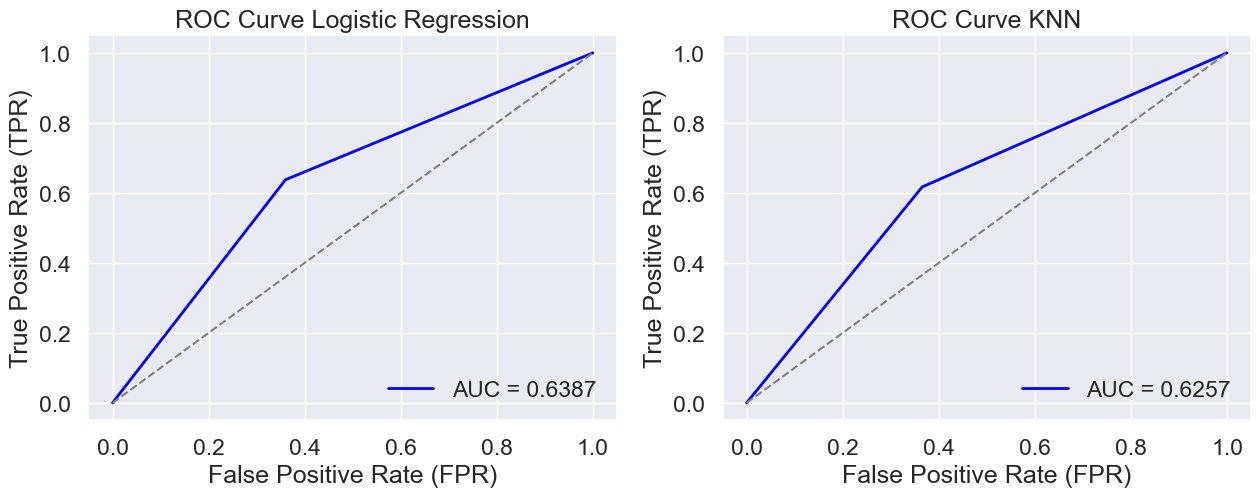

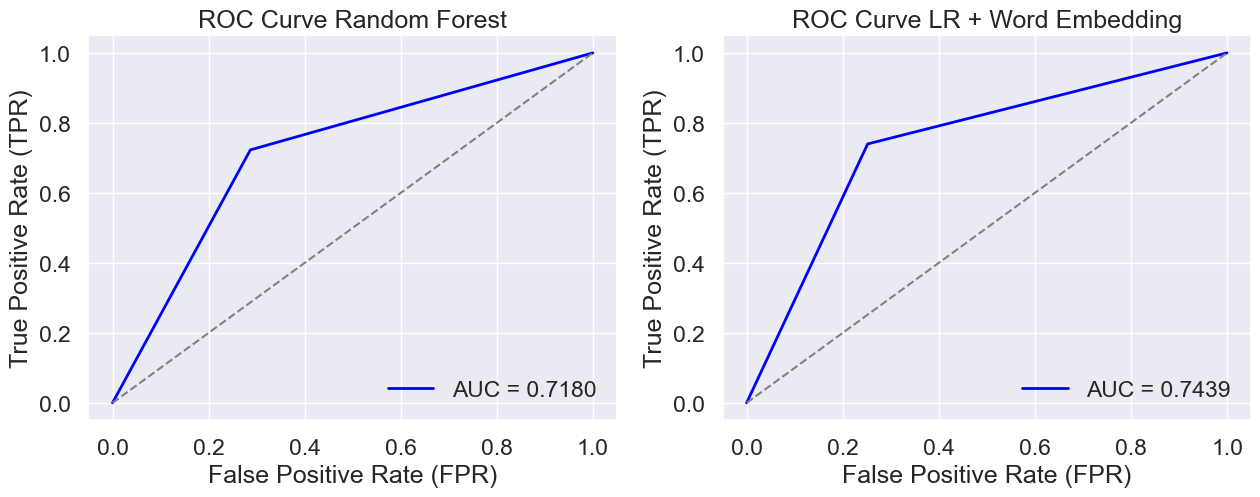

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fpr1 = np.array(roc_curves[0]['fpr'])
tpr1 = np.array(roc_curves[0]['tpr'])
thresholds_roc1 = np.array(roc_curves[0]['thresholds'])
roc_auc1 = roc_curves[0]['auc']

fpr2 = np.array(roc_curves[1]['fpr'])
tpr2 = np.array(roc_curves[1]['tpr'])
thresholds_roc2 = np.array(roc_curves[1]['thresholds'])
roc_auc2 = roc_curves[1]['auc']

axs[0].plot(fpr1, tpr1, color='blue', lw=2, label=f'AUC = {roc_auc1:.4f}')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_xlabel('False Positive Rate (FPR)')
axs[0].set_ylabel('True Positive Rate (TPR)')
axs[0].set_title(f'ROC Curve {models[0]}')
axs[0].legend(loc='lower right')

axs[1].plot(fpr2, tpr2, color='blue', lw=2, label=f'AUC = {roc_auc2:.4f}')
axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1].set_xlabel('False Positive Rate (FPR)')
axs[1].set_ylabel('True Positive Rate (TPR)')
axs[1].set_title(f'ROC Curve {models[1]}')
axs[1].legend(loc='lower right')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fpr3 = np.array(roc_curves[2]['fpr'])
tpr3 = np.array(roc_curves[2]['tpr'])
thresholds_roc2 = np.array(roc_curves[2]['thresholds'])
roc_auc3 = roc_curves[2]['auc']

fpr4 = np.array(roc_curves[3]['fpr'])
tpr4 = np.array(roc_curves[3]['tpr'])
thresholds_roc4 = np.array(roc_curves[3]['thresholds'])
roc_auc4 = roc_curves[3]['auc']

axs[0].plot(fpr3, tpr3, color='blue', lw=2, label=f'AUC = {roc_auc3:.4f}')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_xlabel('False Positive Rate (FPR)')
axs[0].set_ylabel('True Positive Rate (TPR)')
axs[0].set_title(f'ROC Curve {models[2]}')
axs[0].legend(loc='lower right')

axs[1].plot(fpr4, tpr4, color='blue', lw=2, label=f'AUC = {roc_auc4:.4f}')
axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1].set_xlabel('False Positive Rate (FPR)')
axs[1].set_ylabel('True Positive Rate (TPR)')
axs[1].set_title(f'ROC Curve {models[3]}')
axs[1].legend(loc='lower right')
plt.show()

For ROC Curves, it is visible in the graphs that LR + Word Embeddings has the best values being the closest to a perfect curve and AUC about 0.74, then in a similar fashion to the previous metrics, comes Random Forest Classification and at the end both logistic regression and KNN. All models are better than average.

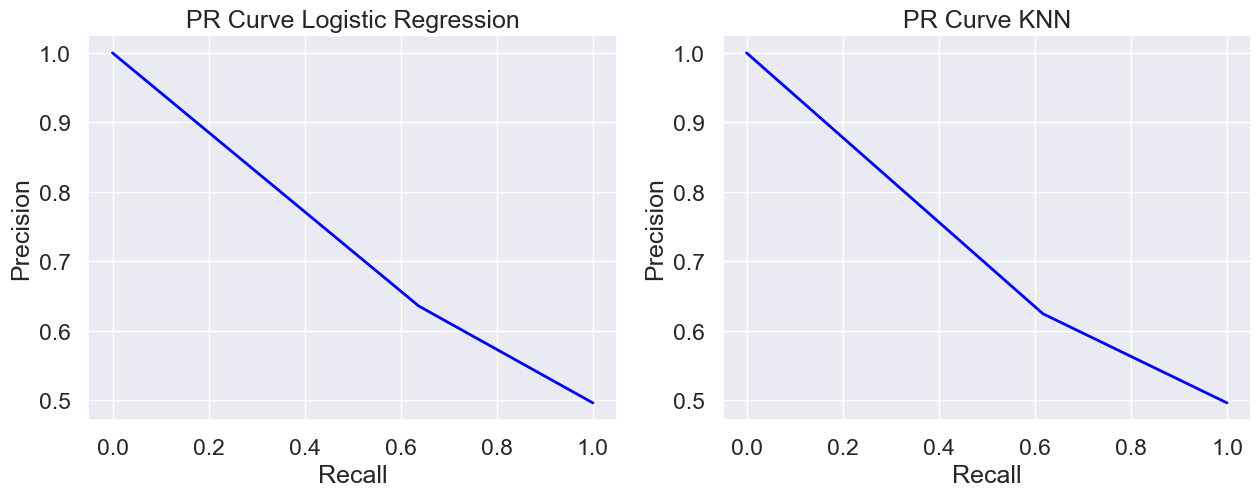

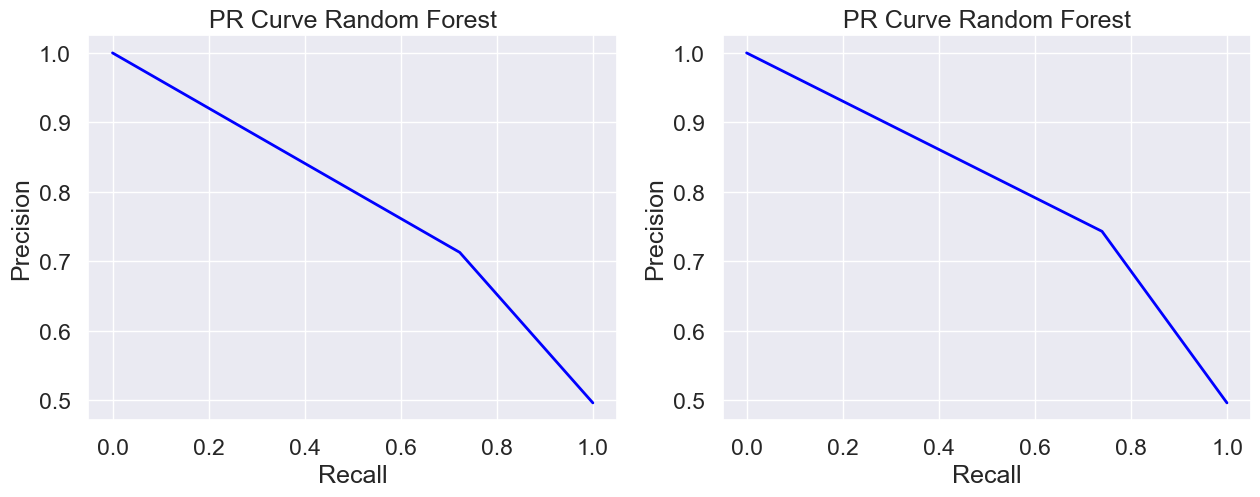

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

precision1 = pr_curves[0]['precision']
recall1 = pr_curves[0]['recall']
thresholds_pr1 = pr_curves[0]['thresholds']
pr_auc1 = pr_curves[0]['auc']

precision2 = pr_curves[1]['precision']
recall2 = pr_curves[1]['recall']
thresholds_pr2 = pr_curves[1]['thresholds']
pr_auc2 = pr_curves[1]['auc']


axs[0].plot(recall1, precision1, color='blue', lw=2, label=f'AUC-PR = {pr_auc1:.4f}')
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title(f'PR Curve {models[0]}')

axs[1].plot(recall2, precision2, color='blue', lw=2, label=f'AUC-PR = {pr_auc2:.4f}')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR Curve {models[1]}')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

precision3 = pr_curves[2]['precision']
recall3 = pr_curves[2]['recall']
thresholds_pr3 = pr_curves[2]['thresholds']
pr_auc3 = pr_curves[2]['auc']

precision4 = pr_curves[3]['precision']
recall4 = pr_curves[3]['recall']
thresholds_pr4 = pr_curves[3]['thresholds']
pr_auc4 = pr_curves[3]['auc']

axs[0].plot(recall3, precision3, color='blue', lw=2, label=f'AUC-PR = {pr_auc3:.4f}')
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title(f'PR Curve {models[2]}')

axs[1].plot(recall4, precision4, color='blue', lw=2, label=f'AUC-PR = {pr_auc4:.4f}')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR Curve {models[2]}')


plt.show()

We can see the same trend going on in PR Curves, meaning that LR + Word Embedding was the best model to use if we were only given textual data. Its scores might be low in our case across most metrics but that might be due to not being able to find a pretrained model for word embeddings that is specified in movie reviews and we werent able to create our own model due to it being computationally heavy and time consuming so we insted used a model trained on Google News. A jump in the metrics is expected with a better pretrained model

## 4.1 Models using originalScore

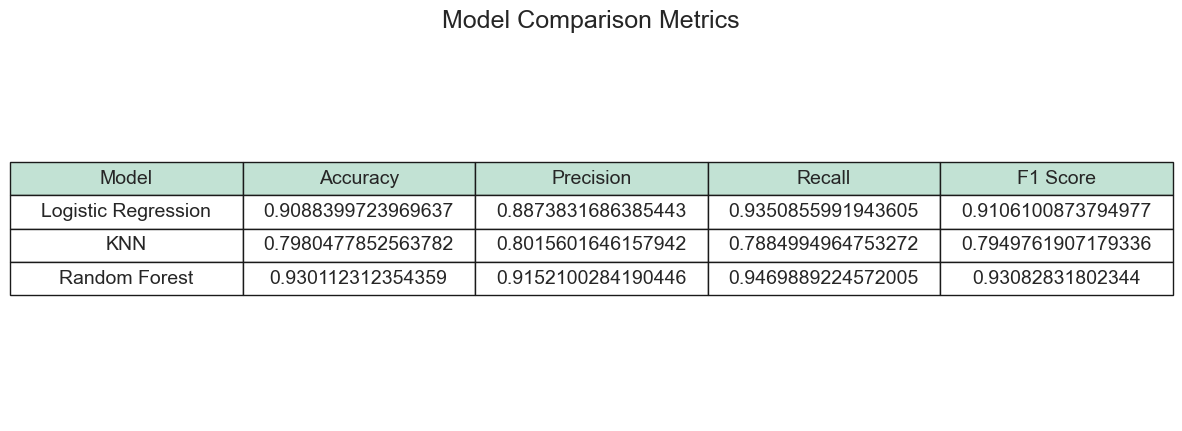

In [160]:
df_results = pd.DataFrame(model_results[i] for i in [3,4,5])

fig, ax = plt.subplots(figsize=(15, 5))

# Hide the axes
ax.axis('off')

# Plot a table
table = ax.table(cellText=df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].values,
                 colLabels=df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].columns,
                 loc='center', cellLoc='center', colColours=['#c2e2d4']*df_results.shape[1])

# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

plt.title('Model Comparison Metrics')
plt.show()

When we use the review score results become much more accurate as expected. The model with the best scores is Random Forest Classification with an average of 93% across all scores and 93% accuracy, while Logistic Regression comes in 2nd place with close values, nearly 90%, and at the end there is KNN with 80% which is way far off.

In [161]:
models = []
precisions = []
recalls = []
matrices = []
roc_curves = []
pr_curves = []

for i in [3,4,5]:
    models.append(model_results[i]['Model'])
    precisions.append(model_results[i]['Precision'])
    recalls.append(model_results[i]['Recall'])
    matrices.append(model_results[i]['Confusion'])
    roc_curves.append(model_results[i]['ROC Curve'])
    pr_curves.append(model_results[i]['PR Curve'])

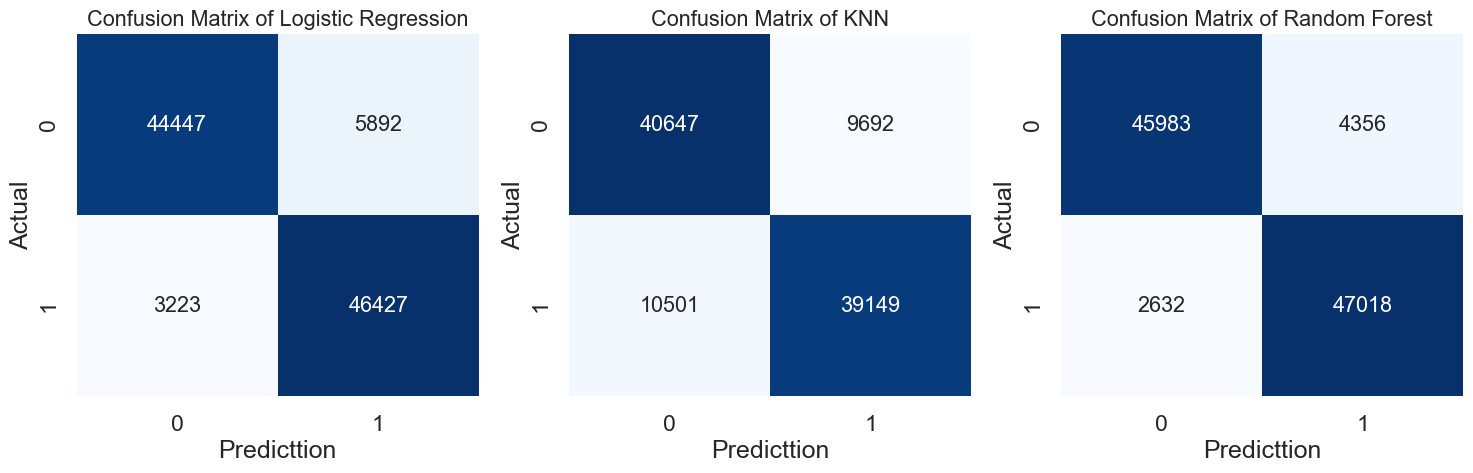

In [162]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.set(font_scale=1.3)

sns.heatmap(matrices[0], annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'], ax=axs[0])

axs[0].set_xlabel('Predicttion')
axs[0].set_ylabel('Actual')
axs[0].set_title(f'Confusion Matrix of {models[0]}')

sns.heatmap(matrices[1], annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'], ax=axs[1])

axs[1].set_xlabel('Predicttion')
axs[1].set_ylabel('Actual')
axs[1].set_title(f'Confusion Matrix of {models[1]}')

sns.heatmap(matrices[2], annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'], ax=axs[2])

axs[2].set_xlabel('Predicttion')
axs[2].set_ylabel('Actual')
axs[2].set_title(f'Confusion Matrix of {models[2]}')

plt.tight_layout()

plt.show()

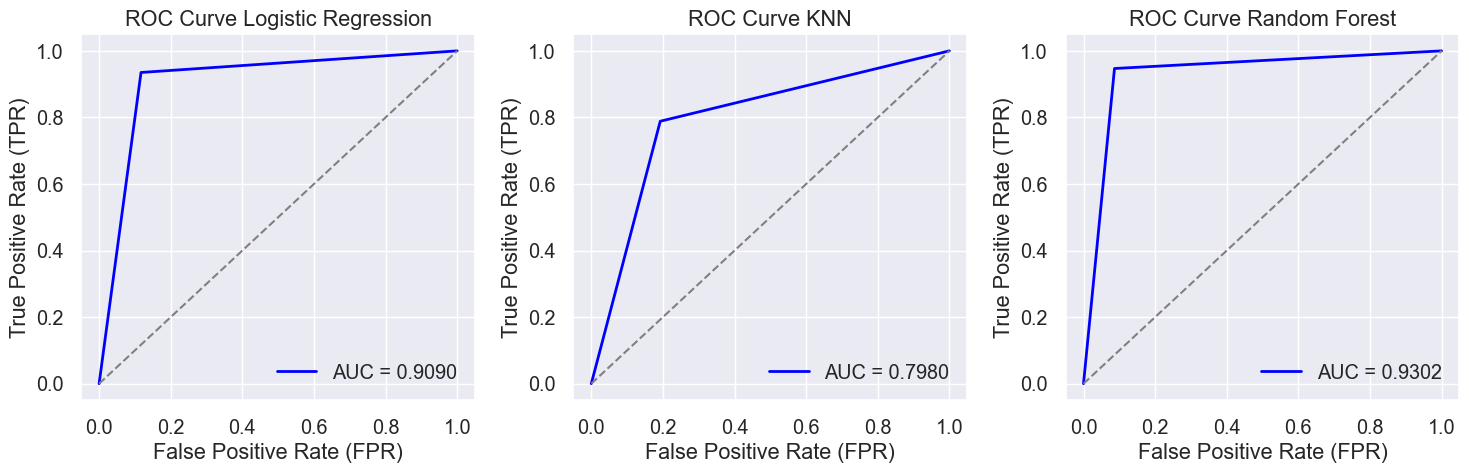

In [166]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fpr1 = np.array(roc_curves[0]['fpr'])
tpr1 = np.array(roc_curves[0]['tpr'])
thresholds_roc1 = np.array(roc_curves[0]['thresholds'])
roc_auc1 = roc_curves[0]['auc']

fpr2 = np.array(roc_curves[1]['fpr'])
tpr2 = np.array(roc_curves[1]['tpr'])
thresholds_roc2 = np.array(roc_curves[1]['thresholds'])
roc_auc2 = roc_curves[1]['auc']

fpr3 = np.array(roc_curves[2]['fpr'])
tpr3 = np.array(roc_curves[2]['tpr'])
thresholds_roc2 = np.array(roc_curves[2]['thresholds'])
roc_auc3 = roc_curves[2]['auc']

axs[0].plot(fpr1, tpr1, color='blue', lw=2, label=f'AUC = {roc_auc1:.4f}')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_xlabel('False Positive Rate (FPR)')
axs[0].set_ylabel('True Positive Rate (TPR)')
axs[0].set_title(f'ROC Curve {models[0]}')
axs[0].legend(loc='lower right')

axs[1].plot(fpr2, tpr2, color='blue', lw=2, label=f'AUC = {roc_auc2:.4f}')
axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1].set_xlabel('False Positive Rate (FPR)')
axs[1].set_ylabel('True Positive Rate (TPR)')
axs[1].set_title(f'ROC Curve {models[1]}')
axs[1].legend(loc='lower right')

axs[2].plot(fpr3, tpr3, color='blue', lw=2, label=f'AUC = {roc_auc3:.4f}')
axs[2].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[2].set_xlabel('False Positive Rate (FPR)')
axs[2].set_ylabel('True Positive Rate (TPR)')
axs[2].set_title(f'ROC Curve {models[2]}')
axs[2].legend(loc='lower right')

plt.tight_layout()
plt.show()

For ROC Curves, We can see from the graphs that Random Forest Classification has the best values being the closest to a perfect curve and AUC about 0.93, then just like previous metrics, comes Logistic Regression and KNN at the end

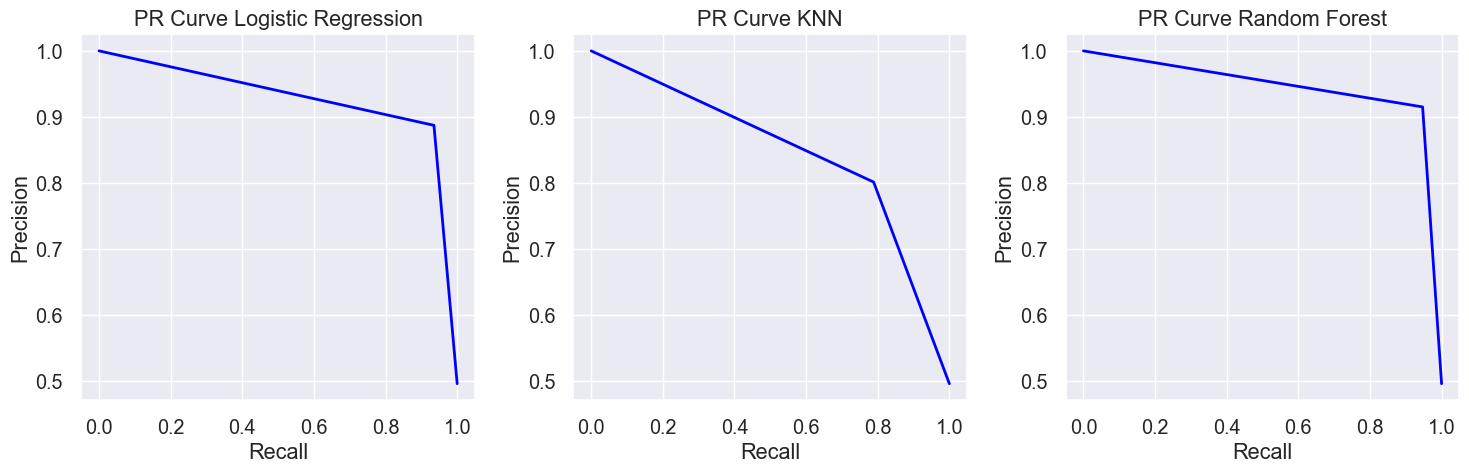

In [164]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

precision1 = pr_curves[0]['precision']
recall1 = pr_curves[0]['recall']
thresholds_pr1 = pr_curves[0]['thresholds']
pr_auc1 = pr_curves[0]['auc']

precision2 = pr_curves[1]['precision']
recall2 = pr_curves[1]['recall']
thresholds_pr2 = pr_curves[1]['thresholds']
pr_auc2 = pr_curves[1]['auc']

precision3 = pr_curves[2]['precision']
recall3 = pr_curves[2]['recall']
thresholds_pr3 = pr_curves[2]['thresholds']
pr_auc3 = pr_curves[2]['auc']

axs[0].plot(recall1, precision1, color='blue', lw=2, label=f'AUC-PR = {pr_auc1:.4f}')
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title(f'PR Curve {models[0]}')

axs[1].plot(recall2, precision2, color='blue', lw=2, label=f'AUC-PR = {pr_auc2:.4f}')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR Curve {models[1]}')

axs[2].plot(recall3, precision3, color='blue', lw=2, label=f'AUC-PR = {pr_auc3:.4f}')
axs[2].set_xlabel('Recall')
axs[2].set_ylabel('Precision')
axs[2].set_title(f'PR Curve {models[2]}')

plt.tight_layout()
plt.show()

We can observe the same trend here, meaning that using original score Random Forest Classification is the best model to use, while in our case KNN was the worst. This might be due to the high dimensionality of the dataset after deducing features from textual data since LR and Random Forest deal with high dimentionality better.